In [2]:
import scanpy as sc
import numpy as np
import scvelo as scv
import cellrank as cr
from cellrank.tl.kernels import CytoTRACEKernel

In [3]:
import scvelo as scv
import dynamo as dyn
import numpy as np
import scanpy as sc
import cellrank as cr
import wandb
import magic
import anndata
from tqdm import tqdm

In [4]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchdiffeq import odeint
# from joblib import Parallel, delayed
# from tqdm import tqdm
# import numpy as np

# class RNAvelo(nn.Module):
#     def __init__(self, feature_size):
#         super(RNAvelo, self).__init__()
#         self.feature_size = feature_size
#         self.log_alpha = nn.Parameter(torch.rand(feature_size))
#         self.log_beta = nn.Parameter(torch.rand(feature_size))
#         self.log_gamma = nn.Parameter(torch.rand(feature_size))
        
#     def forward(self, t, x):
#         # x shape as (n, 2m)
#         if len(x.shape) == 1:
#             du = x[:self.feature_size]
#             ds = x[self.feature_size:]
#             du_dt = torch.square(self.log_alpha) - torch.square(self.log_beta) * du
#             ds_dt = torch.square(self.log_beta) * du - torch.square(self.log_gamma) * ds
#             return torch.cat([du_dt, ds_dt])
            
#         else:
#             du = x[:,:self.feature_size]
#             ds = x[:,self.feature_size:]
        
#             du_dt = torch.square(self.log_alpha) - torch.square(self.log_beta) * du
#             ds_dt = torch.square(self.log_beta) * du - torch.square(self.log_gamma) * ds
        
#             return torch.cat([du_dt, ds_dt],dim=1)
    
#     def params(self,):
#         return torch.square(self.log_alpha).detach().cpu().numpy(), torch.square(self.log_beta).detach().cpu().numpy(), torch.square(self.log_gamma).detach().cpu().numpy()
    
#     def predict(self, t, x):
#         v = self.forward(t,x)
#         v = v.cpu().detach().numpy()
#         return v[:,:self.feature_size], v[:,self.feature_size:]
    
# def fit_neural_ode(u, s, t, num_epochs=300, device='cpu'):
#     # Check if CUDA is available and set the device accordingly
#     if device == 'cuda':
#         device = device if torch.cuda.is_available() else 'cpu'
#     else:
#         device = device
    
#     print(f"Training on device: {device}")
#     # Extract the expression matrix and pseudo-time
    
#     u = torch.tensor(u, dtype=torch.float32).to(device)
#     s = torch.tensor(s, dtype=torch.float32).to(device)
#     expression_matrix = torch.cat([u, s],dim=1)
#     pseudo_time = torch.tensor(t, dtype=torch.float32).to(device)

#     # Feature size is the number of genes (columns) in the expression matrix
#     n_samples, feature_size = u.shape[0], u.shape[1]

#     # Initialize the ODE function with a neural network
#     velo_model = RNAvelo(feature_size=feature_size).to(device)

#     # Define an optimizer
#     optimizer = torch.optim.Adam(velo_model.parameters(), lr=5e-2)

#     # Training loop
#     for epoch in range(num_epochs):
#         optimizer.zero_grad()
#         # Predict the state at the next pseudo-time point
#         predicted = odeint(velo_model, expression_matrix[0], pseudo_time, method='rk4')
#         # Calculate loss (e.g., mean squared error between predicted and actual expression)
#         loss = F.l1_loss(predicted, expression_matrix)
#         # Backpropagation
#         loss.backward()
#         optimizer.step()
#         # if epoch % 10 == 0:
#         #     print(f'Epoch {epoch}: loss = {loss.item()}')
    
#     # After training, use the ODE function to estimate velocity
#     # u_v, s_v = velo_model.predict(pseudo_time, expression_matrix)
#     alpha, beta, gamma = velo_model.params()
#     return alpha, beta, gamma

# def coarse_mode(adata, pt_key='palantir_pseudotime', num_epochs=100):
#     n_samples = adata.shape[0]
    
#     # add small noise to make the time value different
#     adata.obs[pt_key] = adata.obs[pt_key]+0.01*np.random.rand(len(adata.obs[pt_key]))
#     pseudo_time = adata.obs[pt_key].values
#     sorted_indices = np.argsort(pseudo_time)
#     adata = adata[sorted_indices,]
    
#     alpha, beta, gamma = fit_neural_ode(adata.layers['Mu'], adata.layers['Ms'], 
#                                         adata.obs[pt_key].values, num_epochs=num_epochs, device='cpu')
    
#     alpha = np.repeat(alpha.reshape(1, -1), n_samples, axis=0)
#     beta = np.repeat(beta.reshape(1, -1), n_samples, axis=0)
#     gamma = np.repeat(gamma.reshape(1, -1), n_samples, axis=0)
#     adata.layers['alpha'] = alpha
#     adata.layers['beta'] = beta
#     adata.layers['gamma'] = gamma
#     adata.layers['velocity'] = adata.layers['Mu'] * adata.layers['beta'] - adata.layers['Ms'] * adata.layers['gamma']
#     adata.layers['unspliced_velocity'] = adata.layers['alpha'] - adata.layers['Mu'] * adata.layers['beta']
    
#     return adata

# # Assume coarse_mode function is defined above or imported

# # This function will process each group in parallel
# def process_group(adata, group, group_value, pt_key='palantir_pseudotime', num_epochs=100):
#     adata = adata[adata.obs[group] == group_value].copy()
    
#     adata = coarse_mode(adata, pt_key=pt_key, num_epochs=num_epochs)
#     return adata

# # Modified coarse_grained_kinetics function to use joblib for parallel processing
# def coarse_grained_kinetics(adata, pt_key, group, num_epochs=100, n_jobs=-1):
#     group_values = adata.obs[group].value_counts().index

#     # Run the processing in parallel
#     adata_list = Parallel(n_jobs=n_jobs)(delayed(process_group)(adata, group, group_value, pt_key=pt_key, num_epochs=num_epochs) for group_value in tqdm(group_values))
    
#     # Concatenate the results
#     adata = anndata.concat(adata_list, axis=0)
    
#     return adata

# # This function will be executed in parallel for each cell
# def process_cell(cell_idx, adata, pt_key, num_epochs):
#     adj = adata.obsp['connectivities']
#     neighbor_indices = adj[cell_idx].nonzero()[1]
#     s = adata.layers['Ms'][neighbor_indices, :]
#     u = adata.layers['Mu'][neighbor_indices, :]
#     t = adata.obs[pt_key][neighbor_indices].values
    
#     sorted_indices = np.argsort(t)
#     s = s[sorted_indices, ]
#     u = u[sorted_indices, ]
#     t = t[sorted_indices]
    
#     # Assuming fit_neural_ode is a function that you have defined elsewhere
#     alpha, beta, gamma = fit_ode(u, s, t, num_epochs=num_epochs)
    
#     return alpha, beta, gamma

# # Modified high_resolution_kinetics function to use joblib for parallel processing
# def high_resolution_kinetics(adata, pt_key='palantir_pseudotime', num_epochs=100, n_jobs=-1):
#     # Initialize matrices
#     alpha = np.zeros((adata.shape[0], adata.shape[1]))
#     beta = np.zeros((adata.shape[0], adata.shape[1]))
#     gamma = np.zeros((adata.shape[0], adata.shape[1]))
    
#     # add small noise to make the time value different
#     adata.obs['ct_pseudotime'] = adata.obs['ct_pseudotime']+np.random.rand(len(adata.obs['ct_pseudotime']))
#     pseudo_time = adata.obs['ct_pseudotime'].values
#     sorted_indices = np.argsort(pseudo_time)
#     adata = adata[sorted_indices,]
    
#     # Run in parallel
#     results = Parallel(n_jobs=n_jobs)(delayed(process_cell)(cell_idx, adata, pt_key, num_epochs) for cell_idx in tqdm(range(adata.shape[0])))

#     # Unpack results
#     for i, (alpha_i, beta_i, gamma_i) in enumerate(results):
#         alpha[i,] = alpha_i
#         beta[i,] = beta_i
#         gamma[i,] = gamma_i

#     # Store results in adata
#     adata.layers['alpha'] = alpha
#     adata.layers['beta'] = beta
#     adata.layers['gamma'] = gamma
#     adata.layers['velocity'] = adata.layers['Mu'] * beta - adata.layers['Ms'] * gamma
#     adata.layers['unspliced_velocity'] = alpha - adata.layers['Mu'] * beta
    
#     return adata

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint

class RNAvelo(nn.Module):
    def __init__(self, feature_size):
        super(RNAvelo, self).__init__()
        self.feature_size = feature_size
        self.log_alpha = nn.Parameter(torch.rand(feature_size))
        self.log_beta = nn.Parameter(torch.rand(feature_size))
        self.log_gamma = nn.Parameter(torch.rand(feature_size))
        
    def forward(self, t, x):
        # x shape as (n, 2m)
        if len(x.shape) == 1:
            du = x[:self.feature_size]
            ds = x[self.feature_size:]
            du_dt = torch.exp(self.log_alpha) - torch.exp(self.log_beta) * du
            ds_dt = torch.exp(self.log_beta) * du - torch.exp(self.log_gamma) * ds
            return torch.cat([du_dt, ds_dt])
            
        else:
            du = x[:,:self.feature_size]
            ds = x[:,self.feature_size:]
        
            du_dt = torch.exp(self.log_alpha) - torch.exp(self.log_beta) * du
            ds_dt = torch.exp(self.log_beta) * du - torch.exp(self.log_gamma) * ds
        
            return torch.cat([du_dt, ds_dt],dim=1)
    
    def params(self,):
        return torch.exp(self.log_alpha).detach().cpu().numpy(), torch.exp(self.log_beta).detach().cpu().numpy(), torch.exp(self.log_gamma).detach().cpu().numpy()
    
    def predict(self, t, x):

        v = self.forward(t,x)
        v = v.cpu().detach().numpy()
        return v[:,:self.feature_size], v[:,self.feature_size:]

def fit_neural_ode(adata, num_epochs=300, device='cuda'):
    # Sort adata based on pseudo-time
    pseudo_time = adata.obs['ct_pseudotime'].values
    sorted_indices = np.argsort(pseudo_time)
    adata = adata[sorted_indices,]
    # Check if CUDA is available and set the device accordingly
    if device == 'cuda':
        device = device if torch.cuda.is_available() else 'cpu'
    else:
        device = device
    
    print(f"Training on device: {device}")
    # Extract the expression matrix and pseudo-time
    
    u = torch.tensor(adata.layers['Mu'], dtype=torch.float32).to(device)
    s = torch.tensor(adata.layers['Ms'], dtype=torch.float32).to(device)
    expression_matrix = torch.cat([u, s],dim=1)
    pseudo_time = torch.tensor(adata.obs['ct_pseudotime'], dtype=torch.float32).to(device)

    # Feature size is the number of genes (columns) in the expression matrix
    n_samples, feature_size = u.shape[0], u.shape[1]

    # Initialize the ODE function with a neural network
    velo_model = RNAvelo(feature_size=feature_size).to(device)

    # Define an optimizer
    optimizer = torch.optim.Adam(velo_model.parameters(), lr=5e-2)

    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        # Predict the state at the next pseudo-time point
        predicted = odeint(velo_model, expression_matrix[0], pseudo_time)
        # Calculate loss (e.g., mean squared error between predicted and actual expression)
        loss = F.l1_loss(predicted, expression_matrix)
        # Backpropagation
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: loss = {loss.item()}')
    
    # After training, use the ODE function to estimate velocity
    u_v, s_v = velo_model.predict(pseudo_time, expression_matrix)
    alpha, beta, gamma = velo_model.params()
    alpha = np.repeat(alpha.reshape(1, -1), n_samples, axis=0)
    beta = np.repeat(beta.reshape(1, -1), n_samples, axis=0)
    gamma = np.repeat(gamma.reshape(1, -1), n_samples, axis=0)
    
    adata.layers['alpha'] = alpha
    adata.layers['beta'] = beta
    adata.layers['gamma'] = gamma
    adata.layers['velocity'] = s_v
    adata.layers['unspliced_velocity'] = u_v
    
    return adata

In [6]:
# adata = sc.read('./palantir/palantir_gastrulation.h5ad')

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:19) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:09) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


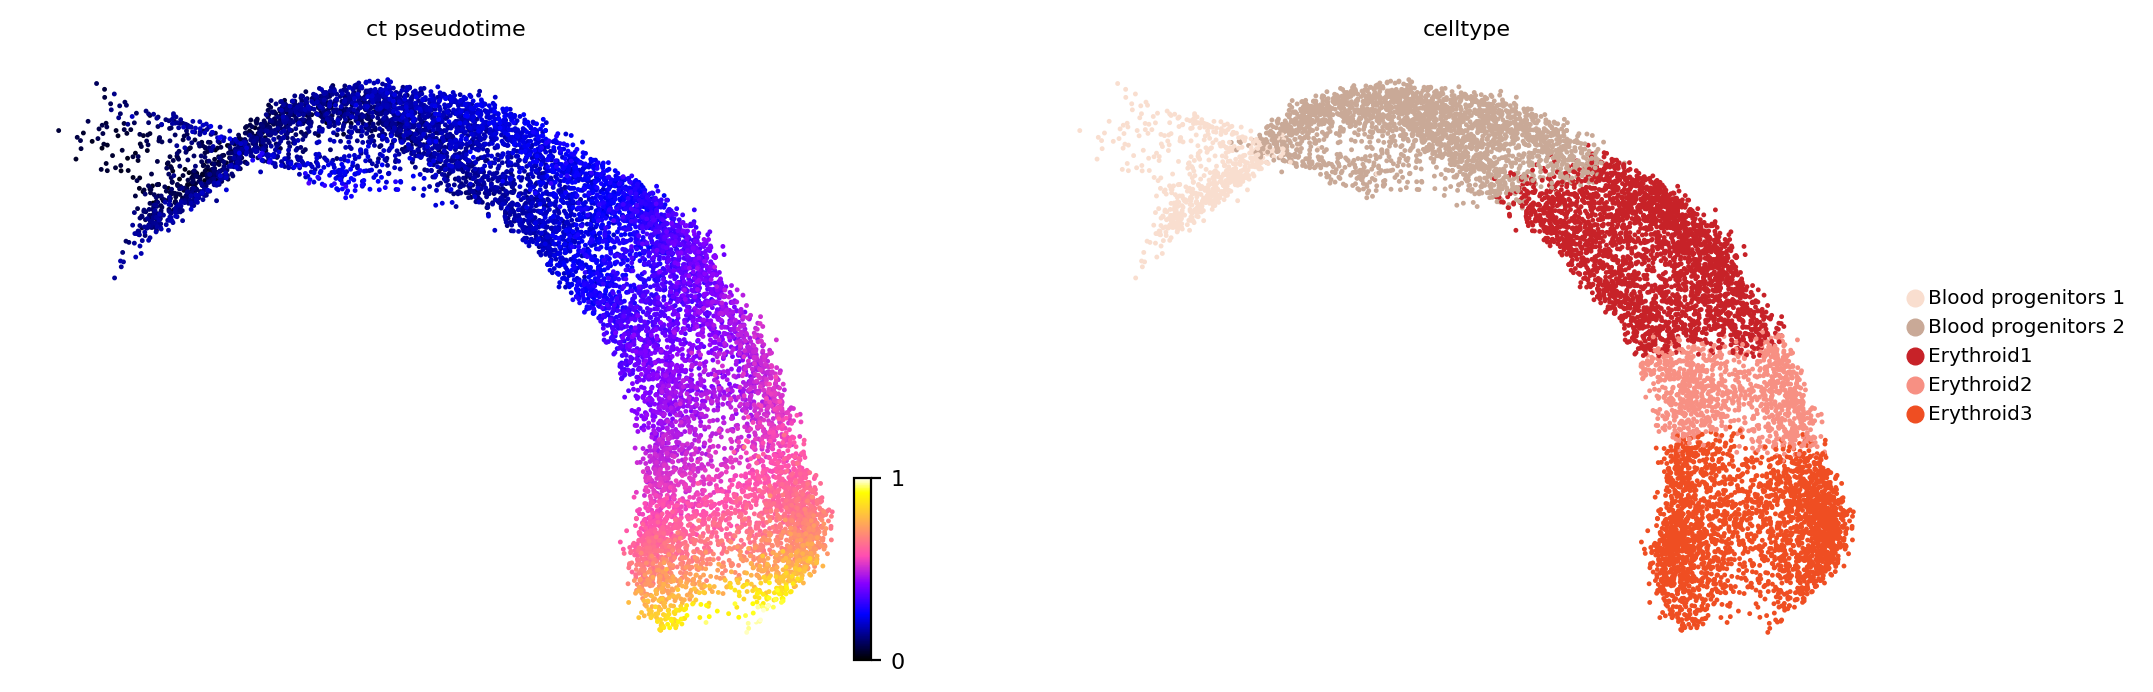

In [7]:
adata = scv.datasets.gastrulation_erythroid()
scv.pp.filter_and_normalize(adata, n_top_genes=None)
scv.pp.moments(adata,  n_neighbors=30)
ctk = CytoTRACEKernel(adata)
scv.pl.scatter(
    adata,
    c=["ct_pseudotime", "celltype"],
    legend_loc="right",
    color_map="gnuplot2",
)

In [8]:
pt = adata.obs['ct_pseudotime']

In [ ]:
adata = scv.datasets.gastrulation_erythroid()
murk_genes = adata.var.index[adata.var['MURK_gene'] == True]
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, retain_genes=murk_genes)
# n_neighbors = int(np.sqrt(adata.shape[0]))
scv.pp.moments(adata, n_neighbors=30)
adata.obs['ct_pseudotime'] = pt

In [10]:
adata_list = []
for i in adata.obs['celltype'].value_counts().index:
    print(i)
    adata_i = adata[adata.obs['celltype'] == i].copy()
    adata_i.obs['ct_pseudotime'] = adata_i.obs['ct_pseudotime']+0.01*np.random.rand(len(adata_i.obs['ct_pseudotime']))
    pseudo_time = adata_i.obs['ct_pseudotime'].values
    sorted_indices = np.argsort(pseudo_time)
    adata_i = adata_i[sorted_indices,]
    
    adata_i = fit_neural_ode(adata_i, num_epochs=200)
    adata_list.append(adata_i)

adata = anndata.concat(adata_list, axis=0)

Erythroid1
Training on device: cuda
Epoch 0: loss = 0.5409873127937317
Epoch 10: loss = 0.38268426060676575
Epoch 20: loss = 0.3006330728530884
Epoch 30: loss = 0.2614821493625641
Epoch 40: loss = 0.24234133958816528
Epoch 50: loss = 0.23125827312469482
Epoch 60: loss = 0.22230425477027893
Epoch 70: loss = 0.21274544298648834
Epoch 80: loss = 0.20261424779891968
Epoch 90: loss = 0.18958182632923126
Epoch 100: loss = 0.18166056275367737
Epoch 110: loss = 0.1759038269519806
Epoch 120: loss = 0.17362520098686218
Epoch 130: loss = 0.173817977309227
Epoch 140: loss = 0.1738060861825943
Epoch 150: loss = 0.17359784245491028
Epoch 160: loss = 0.1732342392206192
Epoch 170: loss = 0.1728297621011734
Epoch 180: loss = 0.17242595553398132
Epoch 190: loss = 0.17198723554611206
Erythroid3
Training on device: cuda
Epoch 0: loss = 0.7535353302955627
Epoch 10: loss = 0.5803877115249634
Epoch 20: loss = 0.48992329835891724
Epoch 30: loss = 0.44342106580734253
Epoch 40: loss = 0.4183591604232788
Epoch 5

In [1]:
# adata = coarse_grained_kinetics(adata, pt_key='ct_pseudotime', group='celltype', num_epochs=200)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 16/16 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

/home/cys/miniconda3/envs/velo/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:33) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


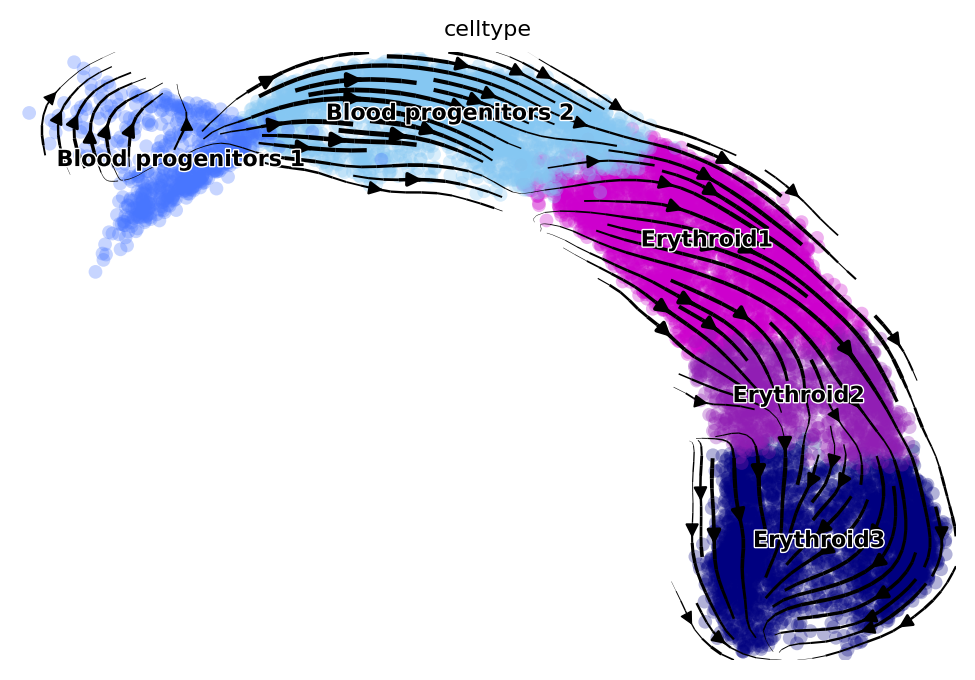

In [47]:

scv.pl.velocity_embedding_stream(adata, basis='umap',c='celltype')

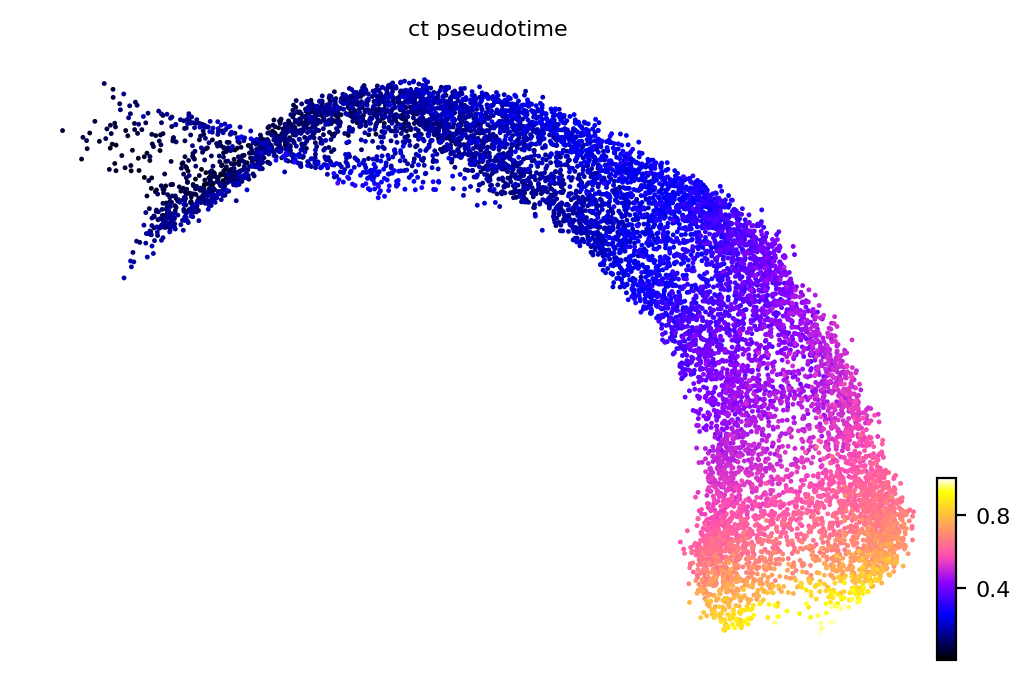

In [48]:
scv.pl.scatter(
    adata,
    c=["ct_pseudotime"],
    legend_loc="right",
    color_map="gnuplot2",
)

In [49]:
for i in range(adata.shape[1]):
    if adata.var.index[i] == 'Hba-x':
        print(i)
        
adata.var.loc['Hba-x']

307


Series([], Name: Hba-x, dtype: float64)

In [50]:
# adata.obs['pseudotime'] = adata.obs['palantir_pseudotime']

In [51]:
i = 307

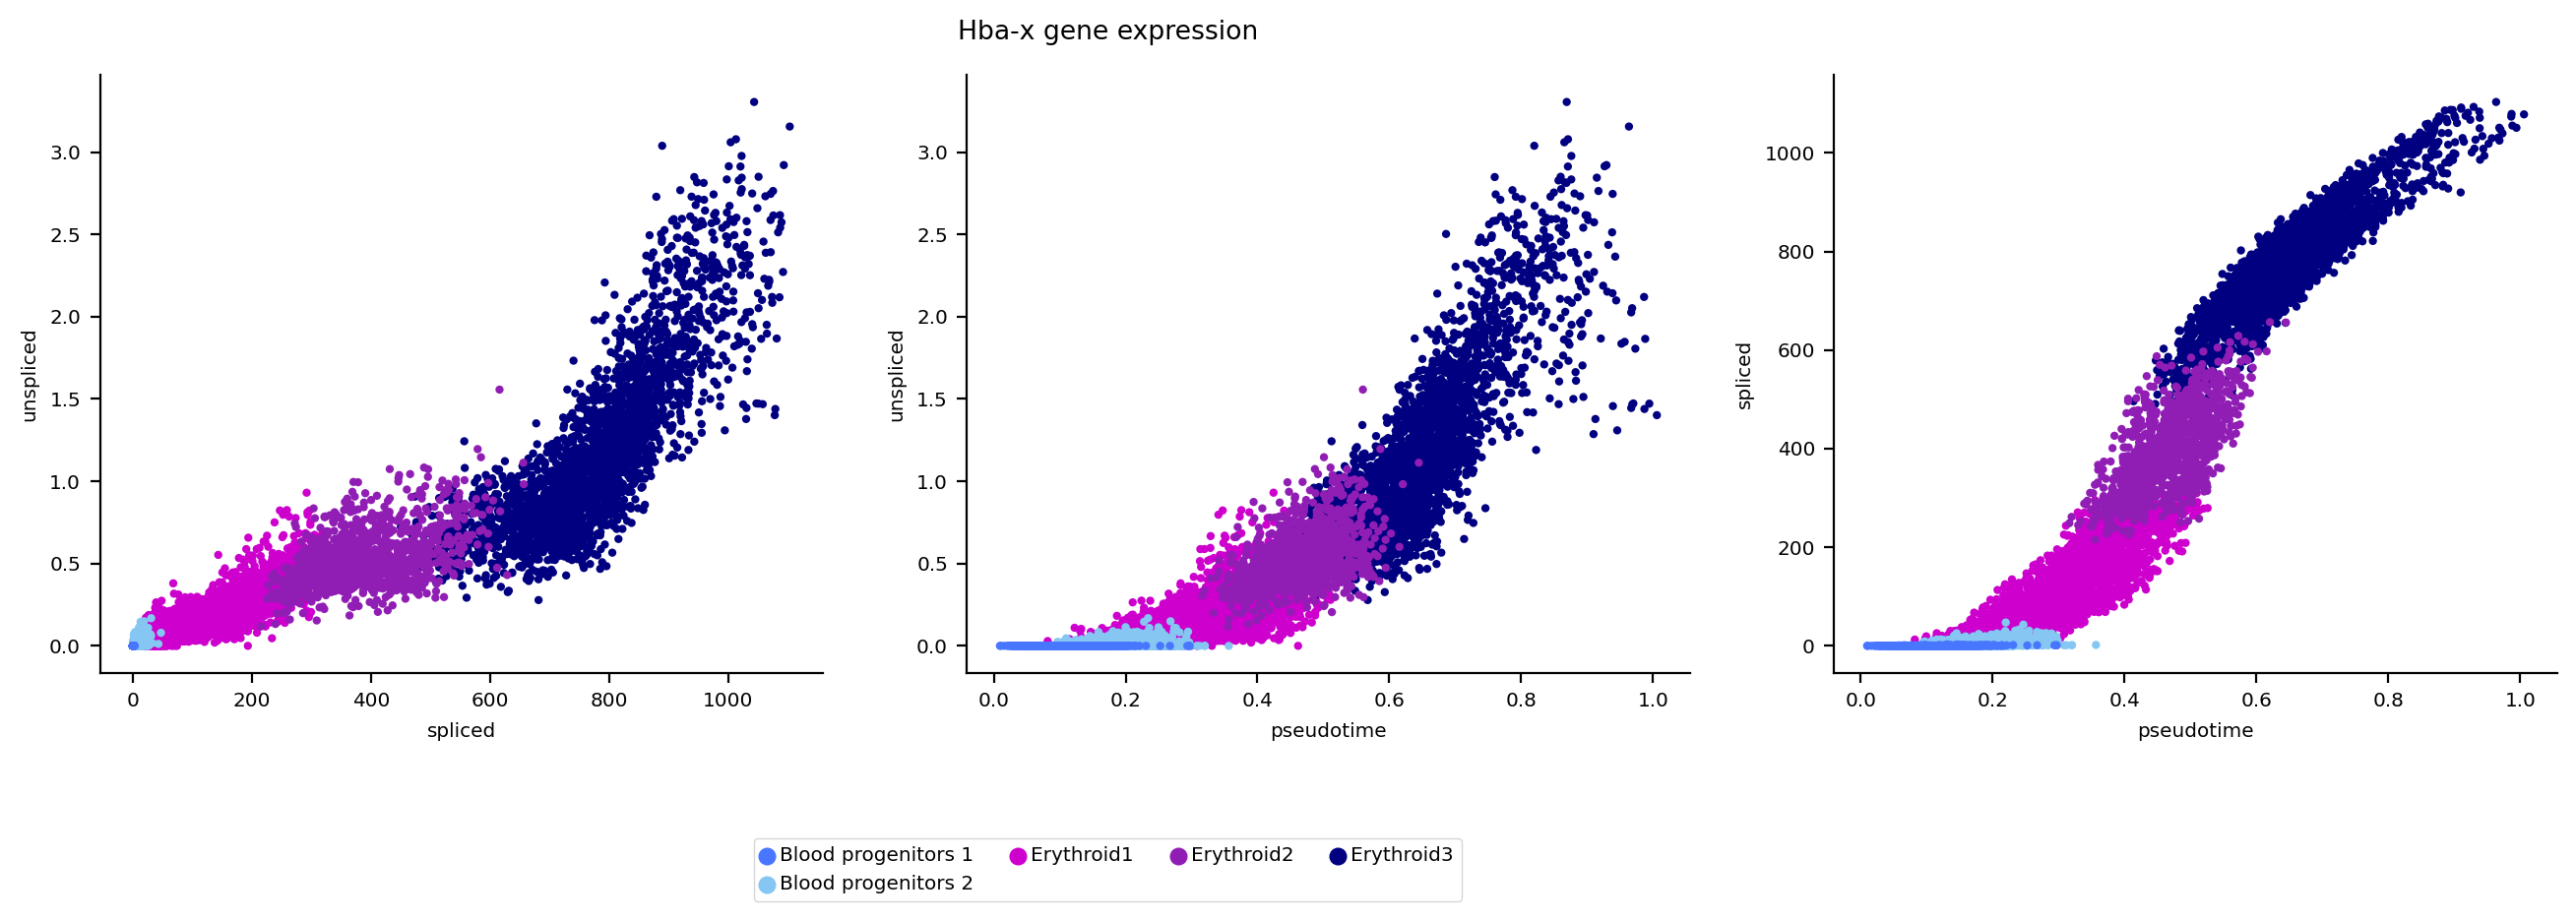

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1
sns.scatterplot(x=np.array(adata.layers['Ms'][:, i]).reshape(-1),
                y=np.array(adata.layers['Mu'][:, i]).reshape(-1),
                hue=adata.obs['celltype'], marker='.', edgecolor='none', ax=axes[0])
axes[0].set_ylabel('unspliced')
axes[0].set_xlabel('spliced')
axes[0].get_legend().remove()

# Plot 2
sns.scatterplot(x=adata.obs['ct_pseudotime'],
                y=np.array(adata.layers['Mu'][:, i]).reshape(-1),
                hue=adata.obs['celltype'], marker='.',edgecolor='none', ax=axes[1])
axes[1].set_ylabel('unspliced')
axes[1].set_xlabel('pseudotime')
axes[1].get_legend().remove()

# Plot 3
sns.scatterplot(x=adata.obs['ct_pseudotime'],
                y=np.array(adata.layers['Ms'][:, i]).reshape(-1),
                hue=adata.obs['celltype'], marker='.', edgecolor='none', ax=axes[2])
axes[2].set_ylabel('spliced')
axes[2].set_xlabel('pseudotime')
axes[2].get_legend().remove()

# Remove top and right spines
for j in range(3):
    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)
handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle(adata.var.iloc[i].name+' gene expression')
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.show()


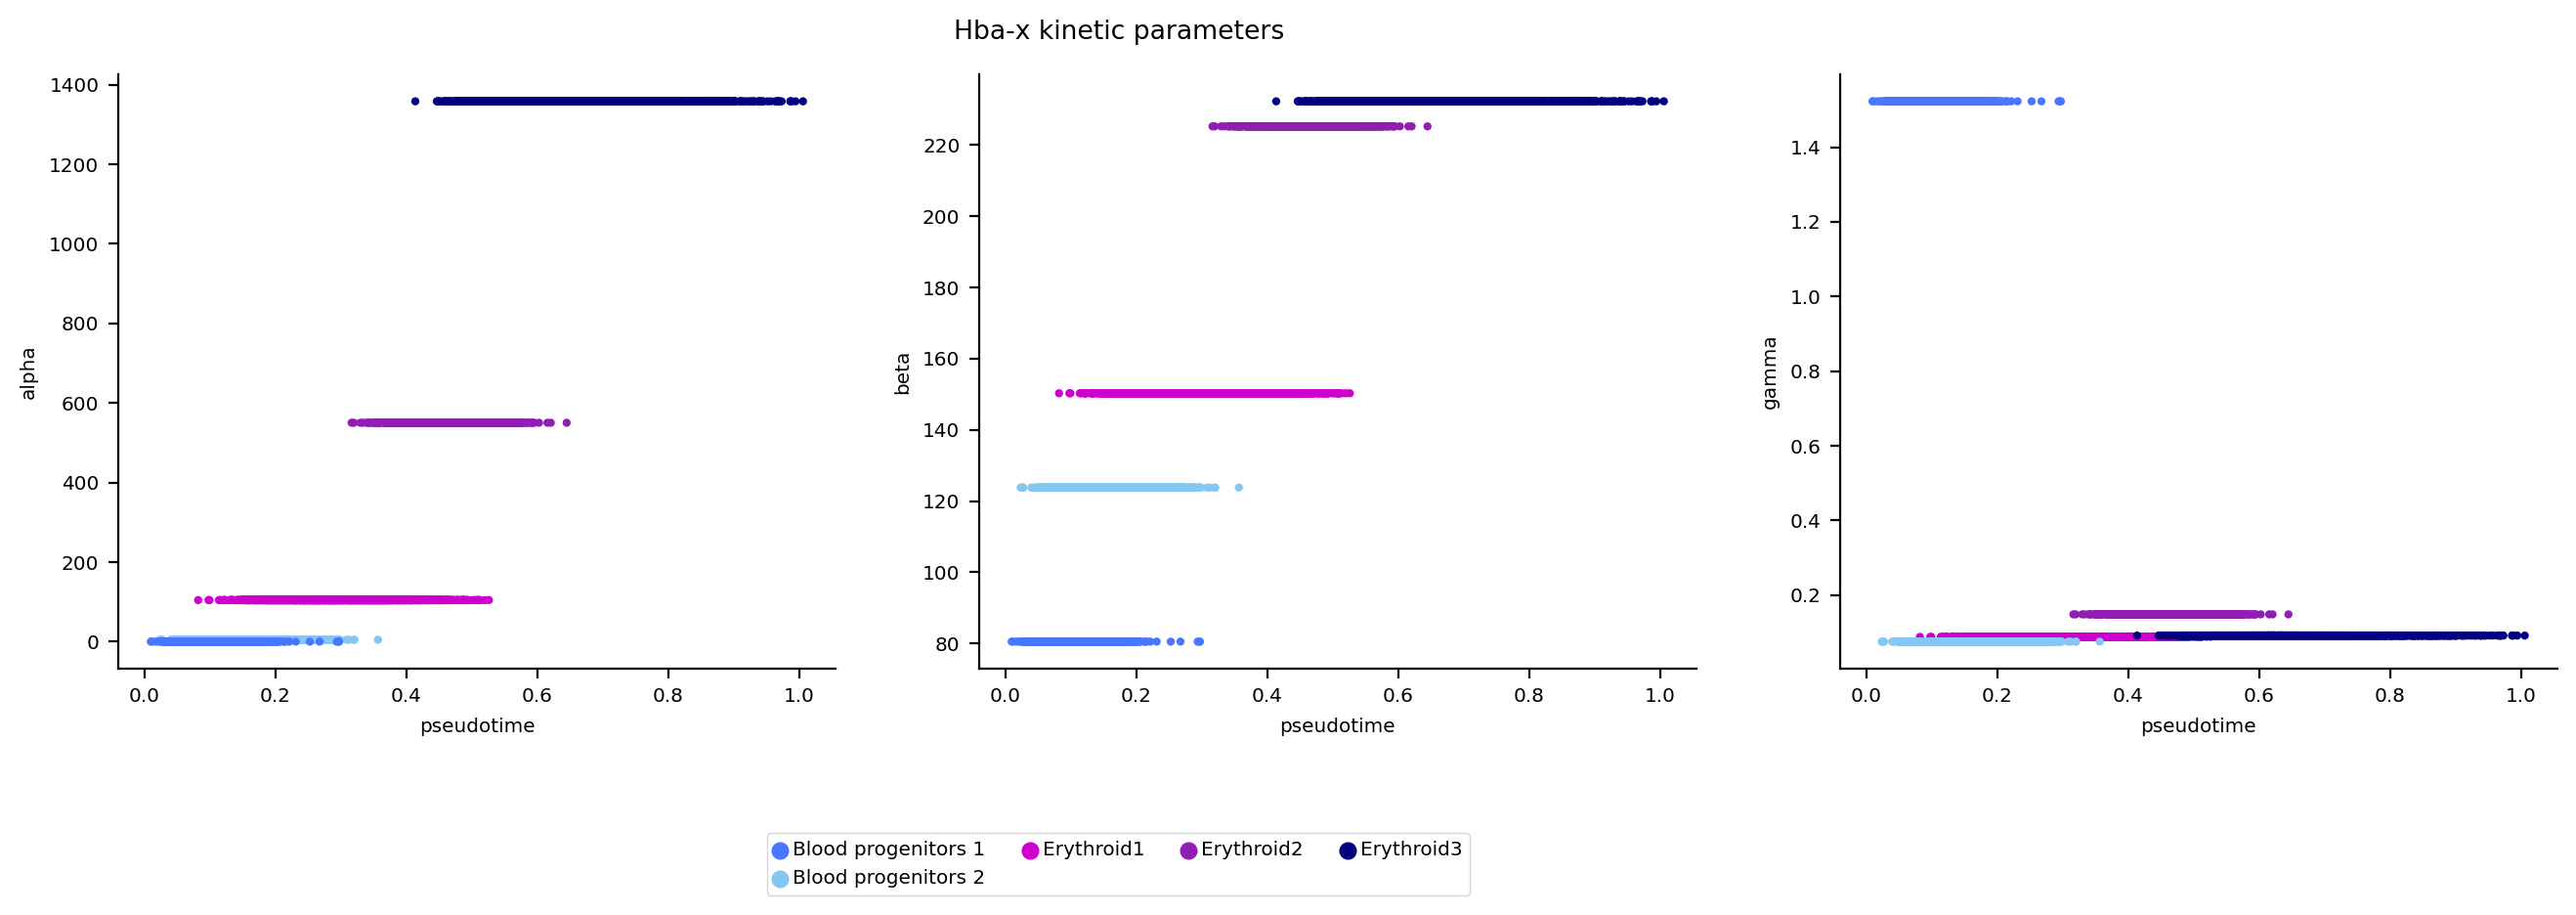

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1
sns.scatterplot(x=adata.obs['ct_pseudotime'],
                y=adata.layers['alpha'][:, i],
                hue=adata.obs['celltype'], marker='.', edgecolor='none', ax=axes[0])
axes[0].set_ylabel('alpha')
axes[0].set_xlabel('pseudotime')
axes[0].get_legend().remove()

# Plot 2
sns.scatterplot(x=adata.obs['ct_pseudotime'],
                y=adata.layers['beta'][:, i],
                hue=adata.obs['celltype'], marker='.', edgecolor='none', ax=axes[1])
axes[1].set_ylabel('beta')
axes[1].set_xlabel('pseudotime')
axes[1].get_legend().remove()

# Plot 3
sns.scatterplot(x=adata.obs['ct_pseudotime'],
                y=adata.layers['gamma'][:, i],
                hue=adata.obs['celltype'], marker='.',edgecolor='none', ax=axes[2])
axes[2].set_ylabel('gamma')
axes[2].set_xlabel('pseudotime')
axes[2].get_legend().remove()

# Remove top and right spines
for j in range(3):
    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)

# Get handles and labels for the legend
handles, labels = axes[0].get_legend_handles_labels()

fig.suptitle(adata.var.iloc[i].name+' kinetic parameters')

# Create a single legend
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.show()
